<a href="https://colab.research.google.com/github/Kannakattisanjana/Detection_of_malicious_traffic_in_DoH/blob/main/doh(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import sklearn.externals
import joblib 
import IPython.display 
import sklearn.tree 
import pydotplus
import os
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler # Import for standard scaling of the data
from sklearn.preprocessing import MinMaxScaler 

### dataset Details
The dataset used for this research is the CIRA-CIC-DoHBrw-2020 df developed by the Canadian Institute of Cybersecurity.
This df can be found on : ```https://www.unb.ca/cic/dfs/dohbrw-2020.html```

The CIRA-CIC-DoHBrw-2020 df provides 10 days of network traffic from Monday, December 10 to Thursday December 20, 2019. The df consists of 371,836 labelled network flows consisting of 34 features (MontazeriShatoori, et al., 2020).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing the df and outputting the first 5 samples in the df
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/main(BM).csv")
print(df.shape)
df.head(5)

(269643, 36)


,Unnamed: 0,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label
0,0,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:49:11,95.081550,62311,655.342703,65358,...,0.574626,0.001053,0.032457,0.027624,0.026854,0.026822,0.071187,0.024715,1.174948,Benign
1,1,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:50:52,122.309318,93828,767.136973,101232,...,0.509047,0.001170,0.034200,0.024387,0.021043,0.026981,0.293297,-0.075845,1.402382,Benign
2,2,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:52:55,120.958413,38784,320.639127,38236,...,0.732636,0.000785,0.028021,0.029238,0.026922,0.026855,0.248064,0.085061,0.958348,Benign
3,3,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:54:56,110.501080,61993,561.017141,69757,...,0.646859,0.000411,0.020274,0.019925,0.019268,0.026918,0.097199,-0.344926,1.017535,Benign
4,4,176.103.130.131,192.168.20.191,443,50749,2020-01-14 15:56:46,54.229891,83641,1542.341289,76804,...,0.507334,0.079079,0.281209,0.025930,0.000046,0.000021,0.276133,0.092135,10.844829,Benign


In [ ]:
# Analyzing the target class to see how balanced or unbalanced the dataset is.
print(df.groupby('Label').size())

Label
Benign        19807
Malicious    249836
dtype: int64


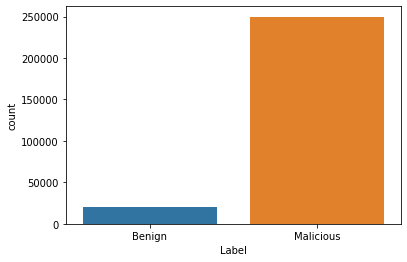

In [ ]:
sns.countplot(x='Label', data=df);

In [ ]:
#checking for the null values and removong.
null = df.isnull()
# print(df.isnull().any().any())
# print(null.sum())
df['ResponseTimeTimeMedian'] = df['ResponseTimeTimeMedian'].fillna(0)
df['ResponseTimeTimeSkewFromMedian'] = df['ResponseTimeTimeSkewFromMedian'].fillna(0)
null = df.isnull()
# print("New: ", df.isnull().any().any())
# print("New: ", null.sum())

### Data Preparation
In this phase, The removal of features with insignificant values was carried out . These features were, Source IP, Destination IP, Packet Time Mode and Timestamp. You may ask, why were these features chosen. Well, Source IP and Destination IP were dropped from the df because in a practical sense, numerous applications exist that randomly generate IP addresses making it not a good feature in training an anomaly detection system. So instead of targeting those features, the machine learning model was trained using data that replicates the behavior of DNS tunneling on the DoH protocol. Timestamp on the other hand was removed because it was observed that it had a high correlation with the target variable. To prevent data leakage, timestamp was removed as a feature. 

In [ ]:
df.head()

,Unnamed: 0,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label
0,0,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:49:11,95.081550,62311,655.342703,65358,...,0.574626,0.001053,0.032457,0.027624,0.026854,0.026822,0.071187,0.024715,1.174948,Benign
1,1,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:50:52,122.309318,93828,767.136973,101232,...,0.509047,0.001170,0.034200,0.024387,0.021043,0.026981,0.293297,-0.075845,1.402382,Benign
2,2,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:52:55,120.958413,38784,320.639127,38236,...,0.732636,0.000785,0.028021,0.029238,0.026922,0.026855,0.248064,0.085061,0.958348,Benign
3,3,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:54:56,110.501080,61993,561.017141,69757,...,0.646859,0.000411,0.020274,0.019925,0.019268,0.026918,0.097199,-0.344926,1.017535,Benign
4,4,176.103.130.131,192.168.20.191,443,50749,2020-01-14 15:56:46,54.229891,83641,1542.341289,76804,...,0.507334,0.079079,0.281209,0.025930,0.000046,0.000021,0.276133,0.092135,10.844829,Benign


In [ ]:
df = df.drop(['Unnamed: 0'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
df.columns


Index(['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort',
       'TimeStamp', 'Duration', 'FlowBytesSent', 'FlowSentRate',
       'FlowBytesReceived', 'FlowReceivedRate', 'PacketLengthVariance',
       'PacketLengthStandardDeviation', 'PacketLengthMean',
       'PacketLengthMedian', 'PacketLengthMode', 'PacketLengthSkewFromMedian',
       'PacketLengthSkewFromMode', 'PacketLengthCoefficientofVariation',
       'PacketTimeVariance', 'PacketTimeStandardDeviation', 'PacketTimeMean',
       'PacketTimeMedian', 'PacketTimeMode', 'PacketTimeSkewFromMedian',
       'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation',
       'ResponseTimeTimeVariance', 'ResponseTimeTimeStandardDeviation',
       'ResponseTimeTimeMean', 'ResponseTimeTimeMedian',
       'ResponseTimeTimeMode', 'ResponseTimeTimeSkewFromMedian',
       'ResponseTimeTimeSkewFromMode',
       'ResponseTimeTimeCoefficientofVariation', 'Label'],
      dtype='object')

In [ ]:
df.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269643 entries, 0 to 269642
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   SourceIP                                269643 non-null  object 
 1   DestinationIP                           269643 non-null  object 
 2   SourcePort                              269643 non-null  int64  
 3   DestinationPort                         269643 non-null  int64  
 4   TimeStamp                               269643 non-null  object 
 5   Duration                                269643 non-null  float64
 6   FlowBytesSent                           269643 non-null  int64  
 7   FlowSentRate                            269643 non-null  float64
 8   FlowBytesReceived                       269643 non-null  int64  
 9   FlowReceivedRate                        269643 non-null  float64
 10  PacketLengthVariance                    2696

In [ ]:


df[df.isnull().any(axis=1)]



,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label


In [ ]:
# removal of data samples that contained Na or duplicates
df = df.dropna()
df = df.drop_duplicates()
df

,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label
0,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:49:11,95.081550,62311,655.342703,65358,687.388878,...,0.574626,1.053454e-03,0.032457,0.027624,0.026854,0.026822,0.071187,0.024715,1.174948,Benign
1,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:50:52,122.309318,93828,767.136973,101232,827.672018,...,0.509047,1.169641e-03,0.034200,0.024387,0.021043,0.026981,0.293297,-0.075845,1.402382,Benign
2,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:52:55,120.958413,38784,320.639127,38236,316.108645,...,0.732636,7.851554e-04,0.028021,0.029238,0.026922,0.026855,0.248064,0.085061,0.958348,Benign
3,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:54:56,110.501080,61993,561.017141,69757,631.278898,...,0.646859,4.110453e-04,0.020274,0.019925,0.019268,0.026918,0.097199,-0.344926,1.017535,Benign
4,176.103.130.131,192.168.20.191,443,50749,2020-01-14 15:56:46,54.229891,83641,1542.341289,76804,1416.266907,...,0.507334,7.907866e-02,0.281209,0.025930,0.000046,0.000021,0.276133,0.092135,10.844829,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269638,1.1.1.1,192.168.20.207,443,33926,2020-04-01 00:46:31,120.653838,78776,652.909193,46073,381.861040,...,0.614497,8.716113e-09,0.000093,0.000054,0.000037,0.000028,0.538614,0.275939,1.736555,Malicious
269639,1.1.1.1,192.168.20.207,443,33926,2020-04-01 00:48:32,120.718680,78719,652.086322,46047,381.440553,...,0.615953,8.737216e-07,0.000935,0.000110,0.000032,0.000024,0.250408,0.092028,8.495895,Malicious
269640,1.1.1.1,192.168.20.207,443,33926,2020-04-01 00:50:33,120.645723,78808,653.218349,46118,382.259718,...,0.646320,1.558392e-06,0.001248,0.000128,0.000035,0.000025,0.222679,0.082237,9.778681,Malicious
269641,1.1.1.1,192.168.20.207,443,33926,2020-04-01 00:52:33,120.652326,77281,640.526400,46015,381.385105,...,0.593311,1.055948e-09,0.000032,0.000044,0.000034,0.000017,0.935545,0.819613,0.744732,Malicious


In [ ]:


#Converting object variables to category var
columns = ["SourceIP", "DestinationIP", "Label"]

for col in columns:
    df[col] = df[col].astype('category')



In [ ]:
# df.info(5)

In [ ]:
df_prep = df.copy()

In [ ]:
# df_prep = pd.get_dummies(df_prep, columns = ["SourceIP", "DestinationIP", "SourcePort"])
# df_prep.head()

In [ ]:
df_prep.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label
0,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:49:11,95.081550,62311,655.342703,65358,687.388878,...,0.574626,0.001053,0.032457,0.027624,0.026854,0.026822,0.071187,0.024715,1.174948,Benign
1,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:50:52,122.309318,93828,767.136973,101232,827.672018,...,0.509047,0.001170,0.034200,0.024387,0.021043,0.026981,0.293297,-0.075845,1.402382,Benign
2,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:52:55,120.958413,38784,320.639127,38236,316.108645,...,0.732636,0.000785,0.028021,0.029238,0.026922,0.026855,0.248064,0.085061,0.958348,Benign
3,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:54:56,110.501080,61993,561.017141,69757,631.278898,...,0.646859,0.000411,0.020274,0.019925,0.019268,0.026918,0.097199,-0.344926,1.017535,Benign
4,176.103.130.131,192.168.20.191,443,50749,2020-01-14 15:56:46,54.229891,83641,1542.341289,76804,1416.266907,...,0.507334,0.079079,0.281209,0.025930,0.000046,0.000021,0.276133,0.092135,10.844829,Benign


In [ ]:
cor = df_prep.corr()
cor

,SourcePort,DestinationPort,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,PacketLengthStandardDeviation,PacketLengthMean,...,PacketTimeSkewFromMode,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation
SourcePort,1.000000,-0.912671,-0.451378,-0.380727,-0.077000,-0.130467,-0.067683,0.349936,0.455946,0.408551,...,-0.237858,0.397667,-0.243945,-0.261136,-0.427824,-0.432990,-0.309748,-0.164319,0.082739,-0.291374
DestinationPort,-0.912671,1.000000,0.459331,0.397074,0.080249,0.126426,0.070108,-0.363533,-0.479073,-0.435984,...,0.243176,-0.420330,0.260032,0.275794,0.458269,0.462918,0.334977,0.172657,-0.087082,0.310230
Duration,-0.451378,0.459331,1.000000,0.392683,-0.048065,0.399268,-0.068017,-0.556853,-0.624898,-0.507703,...,0.255292,-0.440094,0.096753,0.115609,0.210733,0.213089,0.160848,0.281645,-0.024214,0.204091
FlowBytesSent,-0.380727,0.397074,0.392683,1.000000,-0.004253,0.805914,-0.007309,-0.258473,-0.292592,-0.178711,...,0.050079,-0.306644,-0.060060,-0.069490,-0.079917,-0.077023,-0.054336,0.174942,-0.090518,0.444507
FlowSentRate,-0.077000,0.080249,-0.048065,-0.004253,1.000000,-0.007315,0.953705,-0.034398,-0.053634,-0.058902,...,0.000331,-0.013892,-0.008514,-0.011701,-0.011572,-0.010772,-0.007613,-0.196095,-0.280201,-0.020761
FlowBytesReceived,-0.130467,0.126426,0.399268,0.805914,-0.007315,1.000000,-0.005030,-0.261383,-0.289972,-0.146197,...,0.080061,-0.314313,-0.064097,-0.077861,-0.086306,-0.081916,-0.057680,0.125345,-0.088679,0.238358
FlowReceivedRate,-0.067683,0.070108,-0.068017,-0.007309,0.953705,-0.005030,1.000000,-0.010042,-0.034902,-0.041785,...,0.018544,-0.031542,-0.012425,-0.016879,-0.016834,-0.015674,-0.011126,-0.202716,-0.281828,-0.026121
PacketLengthVariance,0.349936,-0.363533,-0.556853,-0.258473,-0.034398,-0.261383,-0.010042,1.000000,0.933737,0.788470,...,-0.126865,0.257344,-0.101653,-0.098332,-0.193008,-0.203285,-0.146046,-0.041233,0.235056,-0.142254
PacketLengthStandardDeviation,0.455946,-0.479073,-0.624898,-0.292592,-0.053634,-0.289972,-0.034902,0.933737,1.000000,0.897342,...,-0.247518,0.441827,-0.171733,-0.176322,-0.315512,-0.324317,-0.235894,-0.046446,0.299046,-0.140171
PacketLengthMean,0.408551,-0.435984,-0.507703,-0.178711,-0.058902,-0.146197,-0.041785,0.788470,0.897342,1.000000,...,-0.163016,0.333501,-0.217808,-0.224433,-0.387698,-0.395089,-0.289291,0.069181,0.249886,-0.084865


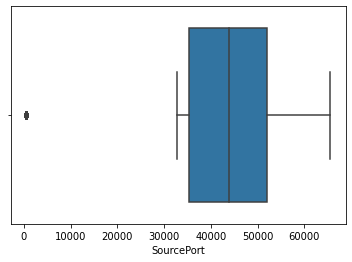

In [ ]:
sns.boxplot(x=df_prep['SourcePort'])

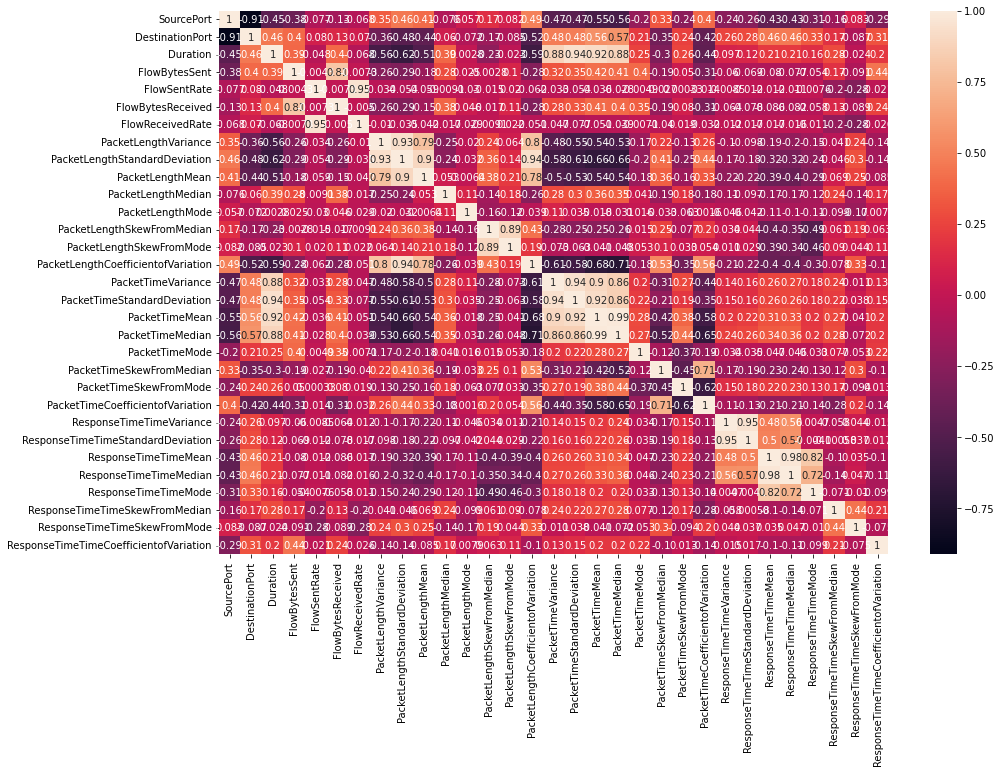

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(data=cor, annot=True)

Text(0.5, 1.0, 'Benign')

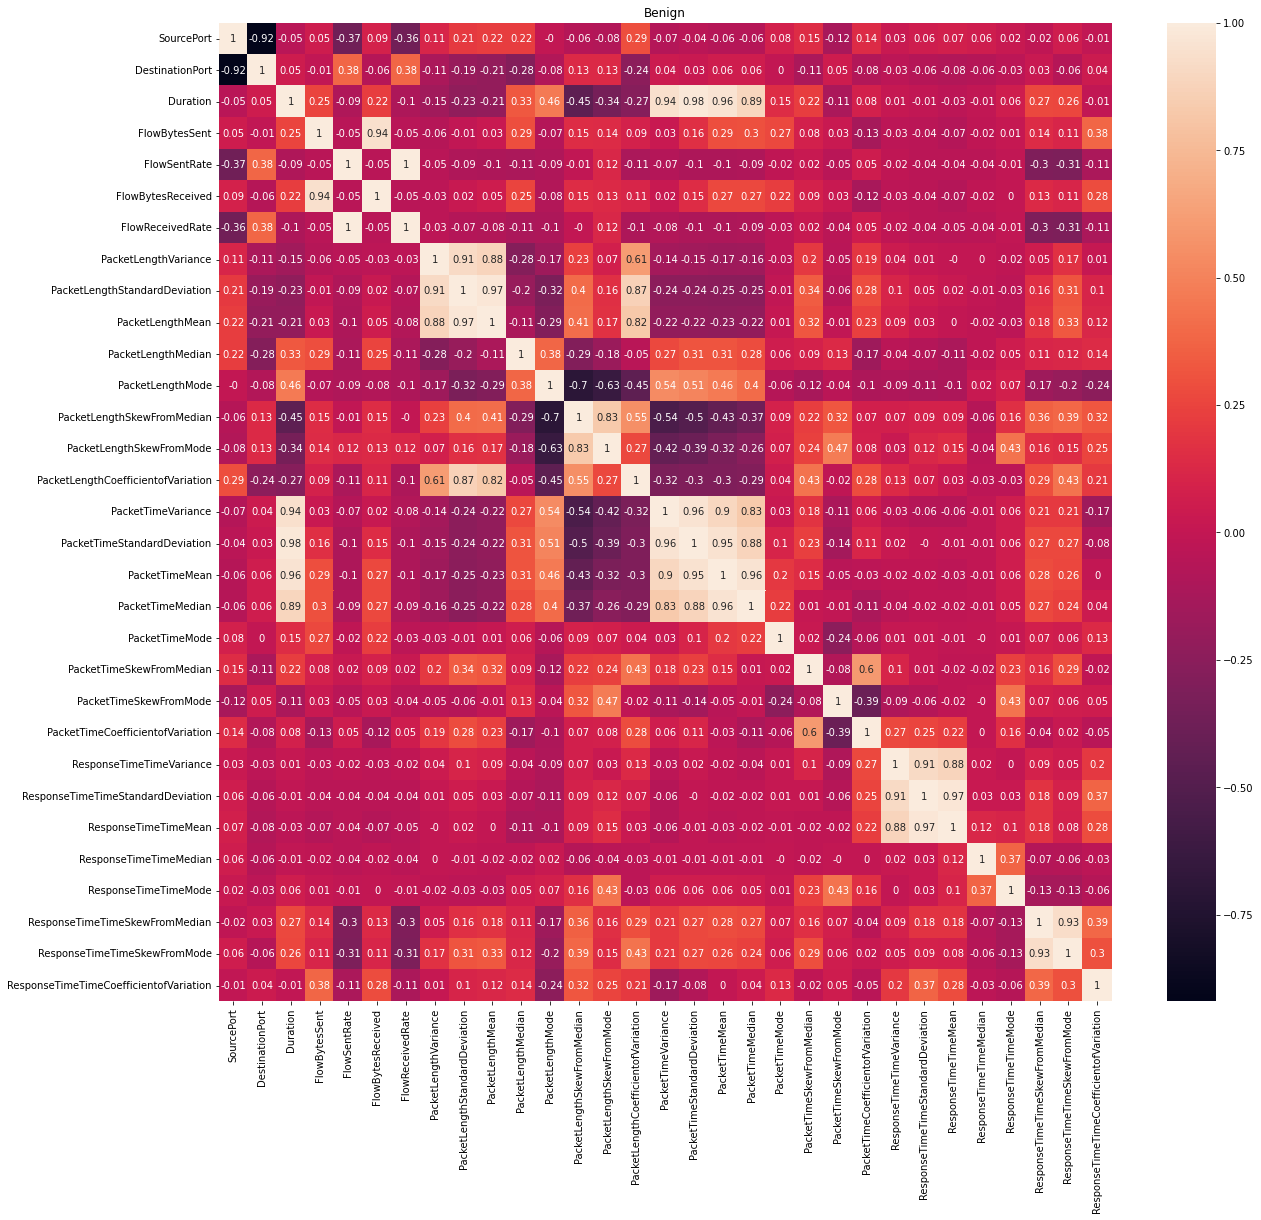

In [ ]:
hep = df_prep.loc[df_prep.Label=="Benign"]

corr_mat_hep = hep.corr().round(2)
corr_mat_hep

plt.figure(figsize=(20,18))
plot = sns.heatmap(hep.corr().round(2), annot= True)
plot.set_title("Benign")

Text(0.5, 1.0, 'Malicious')

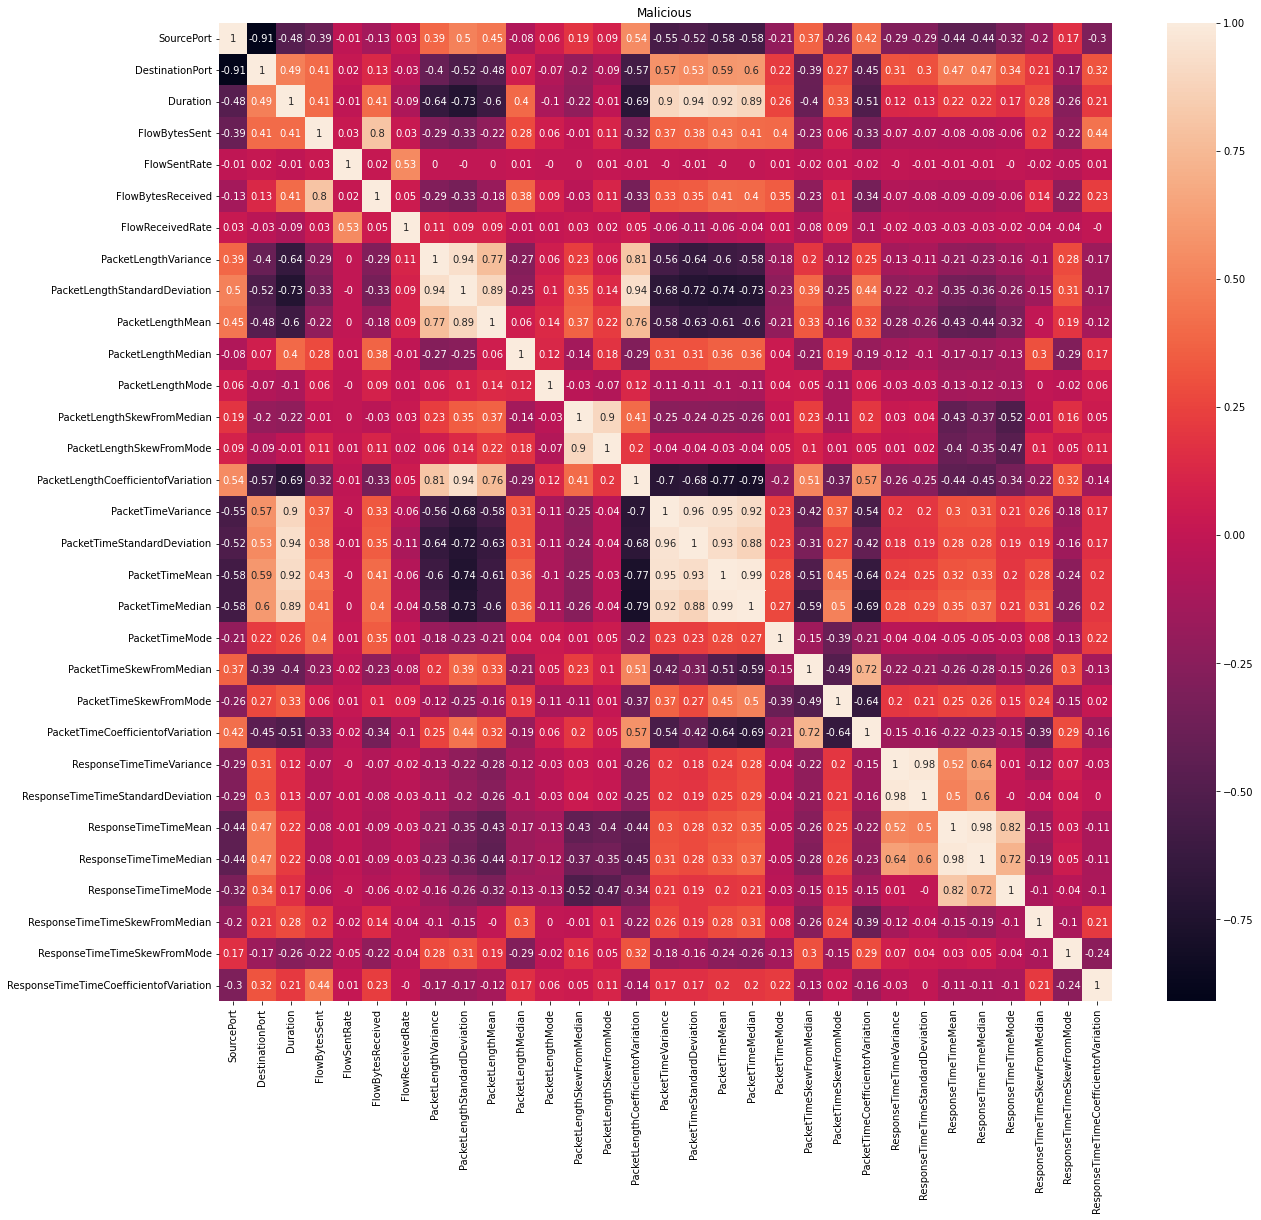

In [ ]:
hep = df_prep.loc[df_prep.Label=="Malicious"]

corr_mat_hep = hep.corr().round(2)
corr_mat_hep

plt.figure(figsize=(20,18))
plot = sns.heatmap(hep.corr().round(2), annot= True)
plot.set_title("Malicious")

In [ ]:
# split dataset in features and target variable

# Features
X = df_prep.drop(columns=["Label"])

# Target variable
y = df_prep['Label']

In [ ]:
# import sklearn packages for data treatments
from sklearn.model_selection import train_test_split # Import train_test_split function

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [ ]:
X_train.shape

(188750, 34)

In [ ]:
y_train.shape

(188750,)

In [ ]:
X_test.shape

(80893, 34)

In [ ]:
y_test.shape

(80893,)

In [ ]:
X_train_temp = X_train.copy()
X_train_temp = X_train_temp.drop(['SourceIP','DestinationIP', 'TimeStamp'],axis=1)
X_test_temp = X_test.copy()
X_test_temp = X_test_temp.drop(['SourceIP','DestinationIP', 'TimeStamp'],axis=1)

In [ ]:
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import StandardScaler # Import for standard scaling of the data
from sklearn.preprocessing import MinMaxScaler # Import for standard scaling of the data

# standard scale data
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_temp)
X_test_scaled = ss.transform(X_test_temp)

# tested MinMaxScaler as KNN historically does better with MinMax
mm = MinMaxScaler()
X_train_mm_scaled = ss.fit_transform(X_train_temp)
X_test_mm_scaled = ss.transform(X_test_temp)

# program to run multilple models though sklearn 
# Default settings output accuracy and classification report
# compares accuracy for scaled and unscaled data
def run_models(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame):
    
    models = [          
          ('Random Forest', RandomForestClassifier(random_state=2020)),
          ('Decision Tree', DecisionTreeClassifier())
        ]  
    
    for name, model in models:        
        # unscaled data
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # scaled data
        clf_scaled = model.fit(X_train_scaled, y_train)
        y_pred_scaled = clf_scaled.predict(X_test_scaled)
        
        # mm scaled data
        clf_mm_scaled = model.fit(X_train_mm_scaled, y_train)
        y_pred_mm_scaled = clf_scaled.predict(X_test_mm_scaled)
        
        # accuracy scores
        accuracy = round(metrics.accuracy_score(y_test, y_pred),5)
        scaled_accuracy = round(metrics.accuracy_score(y_test, y_pred_scaled),5)
        scaled_mm_accuracy = round(metrics.accuracy_score(y_test, y_pred_mm_scaled),5)
        
        # output
        print(name + ':')        
        print("---------------------------------------------------------------")      
        print("Accuracy:", accuracy)
        print("Accuracy w/Scaled Data (ss):", scaled_accuracy)
        print("Accuracy w/Scaled Data (mm):", scaled_mm_accuracy)
        if (accuracy > scaled_accuracy) and (accuracy > scaled_mm_accuracy):
            print("\nClassification Report:\n", metrics.classification_report(y_test, y_pred))      
            print("                            -----------------------------------               \n")      
        elif (scaled_accuracy > scaled_mm_accuracy):
            print("\nClassification Report (ss):\n", metrics.classification_report(y_test, y_pred_scaled))      
            print("                            -----------------------------------               \n")     
        else:            
            print("\nClassification Report (mm):\n", metrics.classification_report(y_test, y_pred_mm_scaled))      
            print("                            -----------------------------------               \n")     

In [ ]:
models = []
models.append(('ETC', ExtraTreesClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))

print(models)



[('ETC', ExtraTreesClassifier()), ('RFC', RandomForestClassifier()), ('DT', DecisionTreeClassifier())]


In [ ]:
results = []
names = []
for name, model in models:
        kfold = model_selection.KFold(n_splits=5, random_state=28, shuffle = True)
        cv_results = model_selection.cross_val_score(model, X_train_temp, y_train, cv=kfold)
        print(cv_results)
        results.append(cv_results)
        names.append(name)
        msg = "%s Accuracy: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

[0.99939073 0.99936424 0.99957616 0.99949669 0.99962914]
ETC Accuracy: 0.999491 (+/- 0.000102)
[0.99962914 0.99986755 0.99992053 0.99976159 0.99986755]
RFC Accuracy: 0.999809 (+/- 0.000104)
[0.99960265 0.99941722 0.99952318 0.99968212 0.9997351 ]
DT Accuracy: 0.999592 (+/- 0.000113)


In [ ]:
from sklearn import metrics

clf = model.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("\nClassification Report:\n", metrics.classification_report(y_test, y_pred)) 


Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      6051
   Malicious       1.00      1.00      1.00     74842

    accuracy                           1.00     80893
   macro avg       1.00      1.00      1.00     80893
weighted avg       1.00      1.00      1.00     80893

